   ---------------------------------------- 38.8/38.8 MB 15.6 MB/s eta 0:00:00
   ---------------------------------------- 14.0/14.0 MB 40.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import cv2
import numpy as np
from skimage import io, morphology, measure
from skimage.io import imread
import os
from scipy.ndimage import binary_dilation, generate_binary_structure
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import matplotlib.colors as mcolors
from skimage import morphology
from scipy.ndimage import binary_erosion, binary_dilation, generate_binary_structure
import matplotlib.patches as mpatches
from scipy.stats import binned_statistic
from scipy.spatial import distance
from skimage.transform import resize
from PIL import Image
from scipy.ndimage import gaussian_filter1d
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io


In [2]:
##import h2b nuclei image
nuclei = io.imread('H:/PROJECTS-03/Agnese/20241004_loopingxutr_moderk_h2b_SU5402-precipitate/20241004_loopingxutr_moderk_h2b/20241004_130442_ctrl/t0001_z129_rot15_ch1_cut.tif')

#import modERK image
mod_erk = io.imread('H:/PROJECTS-03/Agnese/20241004_loopingxutr_moderk_h2b_SU5402-precipitate/20241004_loopingxutr_moderk_h2b/20241004_130442_ctrl/t0001_z129_rot15_ch3_cut.tif')

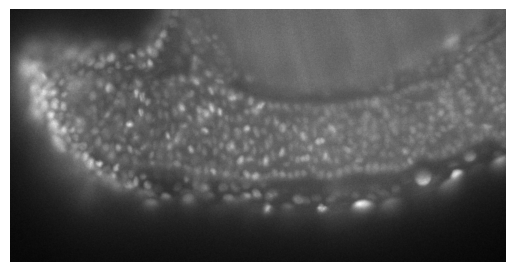

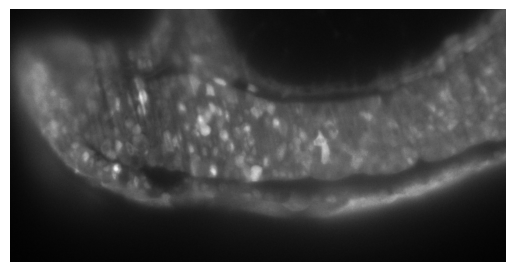

In [3]:
#show image (cmap='gray' for images in gray scale, plt.axis('off') to remove axis)
plt.imshow(nuclei, cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(mod_erk, cmap='gray')
plt.axis('off')
plt.show()

In [4]:
#import nuclear mask
mask = np.load('H:/PROJECTS-03/Agnese/20241004_loopingxutr_moderk_h2b_SU5402-precipitate/20241004_loopingxutr_moderk_h2b/20241004_130442_ctrl/t0001_z129_rot15_ch1_cut_seg.npy', allow_pickle=True)

In [5]:
mask_dict = np.load('H:/PROJECTS-03/Agnese/20241004_loopingxutr_moderk_h2b_SU5402-precipitate/20241004_loopingxutr_moderk_h2b/20241004_130442_ctrl/t0001_z129_rot15_ch1_cut_seg.npy', allow_pickle=True).item()
outlines = mask_dict['outlines']
colors = mask_dict['colors']
masks = mask_dict['masks']

In [9]:
print("Outlines shape:", outlines.shape)
print("Colors shape:", colors.shape)
print("Masks shape:", masks.shape)

Outlines shape: (633, 1242)
Colors shape: (339, 3)
Masks shape: (633, 1242)


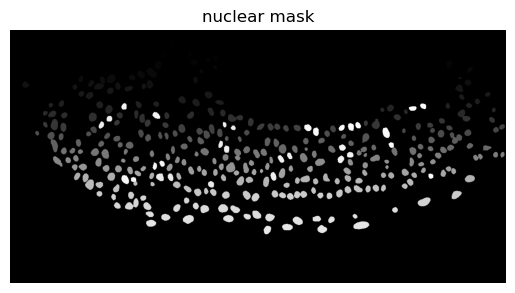

In [10]:
plt.imshow(masks, cmap='gray')
plt.title('nuclear mask')
plt.axis('off')
plt.show()
#why is the mask with different colors?

In [6]:
# Create dictionary with only the cell ID: print ID of cells in the mask

#masks is the array with the cells ID
unique_ids = np.unique(masks)


#create a dictionary to map each ID to its pixels
id_to_pixels = {cell_id: np.argwhere(masks == cell_id) for cell_id in unique_ids if cell_id != 0}




In [7]:
unique_ids = np.unique(masks)

In [8]:
mask1=np.load('H:/PROJECTS-03/Agnese/20241004_loopingxutr_moderk_h2b_SU5402-precipitate/20241004_loopingxutr_moderk_h2b/20241004_130442_ctrl/membrane_mask_seg.npy', allow_pickle=True)

In [9]:
mask_dict1 = np.load('H:/PROJECTS-03/Agnese/20241004_loopingxutr_moderk_h2b_SU5402-precipitate/20241004_loopingxutr_moderk_h2b/20241004_130442_ctrl/membrane_mask_seg.npy', allow_pickle=True).item()
outlines1 = mask_dict1['outlines']
colors1 = mask_dict1['colors']
masks1 = mask_dict1['masks']

In [15]:
print("Outlines shape:", outlines1.shape)
print("Colors shape:", colors1.shape)
print("Masks shape:", masks1.shape)

Outlines shape: (633, 1242)
Colors shape: (193, 3)
Masks shape: (633, 1242)


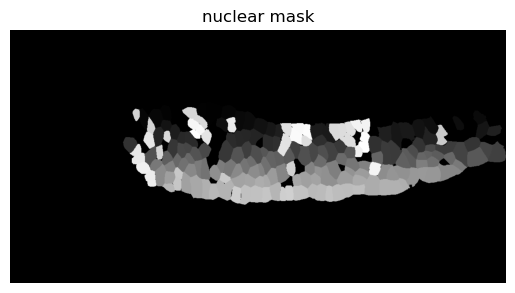

In [16]:
plt.imshow(masks1, cmap='gray')
plt.title('nuclear mask')
plt.axis('off')
plt.show()
#why is the mask with different colors?

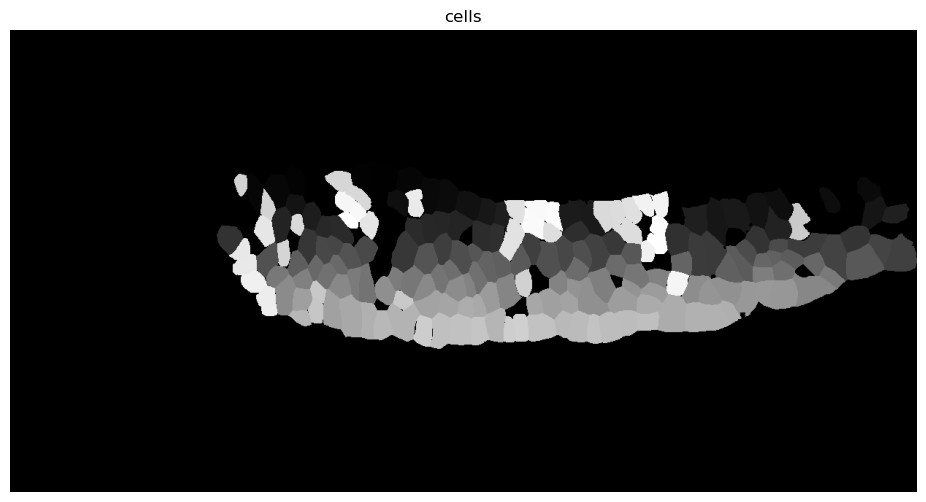

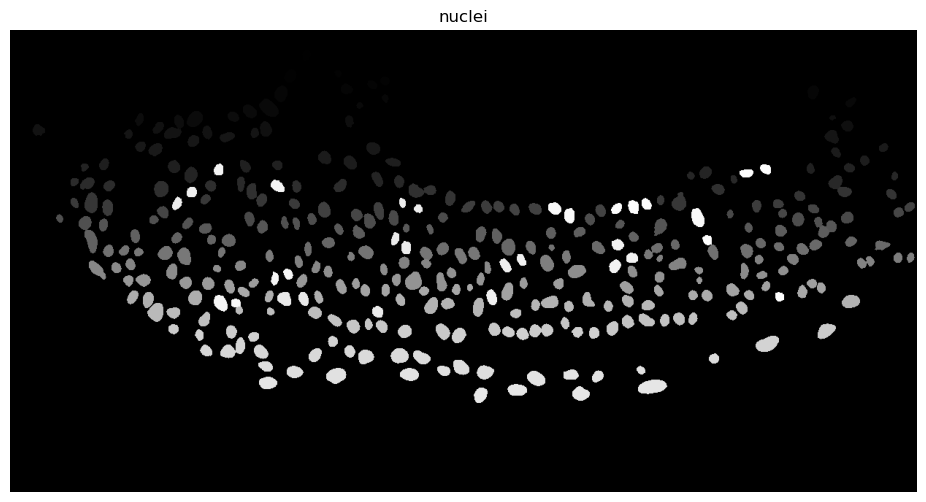

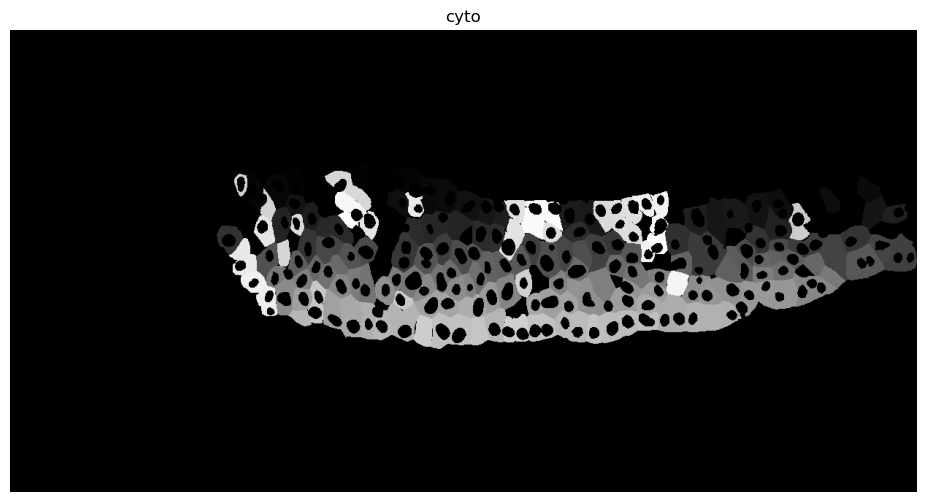

number cyto identified: 193


In [10]:
mask_nuclear = masks   # Maschera del nucleo (ID dei nuclei)
mask_cellular = masks1  # Maschera dell'intera cellula (ID delle cellule)

# Verifica che le maschere abbiano la stessa forma
assert mask_nuclear.shape == mask_cellular.shape, "Le maschere devono avere la stessa forma!"

# Sottrai la maschera nucleare dalla maschera cellulare per ottenere solo il citoplasma
mask_cytoplasm = np.copy(mask_cellular)  # Copia della maschera cellulare
mask_cytoplasm[mask_nuclear != 0] = 0  # Rimuovi i pixel che appartengono al nucleo

# Visualizzazione delle maschere
plt.figure(figsize=(12, 6))
plt.imshow(mask_cellular, cmap='gray')
plt.title('cells')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,6))
plt.imshow(mask_nuclear, cmap='gray')
plt.title('nuclei')
plt.axis('off')
plt.show()

plt.figure(figsize=(12,6))
plt.imshow(mask_cytoplasm, cmap='gray')
plt.title('cyto')
plt.axis('off')

plt.show()

# Crea una nuova maschera dove i citoplasmi hanno lo stesso ID del loro nucleo corrispondente
cytoplasm_with_nuclear_id = np.zeros_like(mask_cytoplasm)

# Mappa ogni citoplasma all'ID del nucleo corrispondente
for cell_id in np.unique(mask_nuclear):
    if cell_id != 0:  # Ignora lo sfondo
        # Assegna lo stesso ID del nucleo ai pixel del citoplasma corrispondente
        cytoplasm_with_nuclear_id[mask_cellular == cell_id] = cell_id

# Mostra il numero di citoplasmi rilevati
unique_cytoplasms = np.unique(cytoplasm_with_nuclear_id)
print(f"number cyto identified: {len(unique_cytoplasms) - 1}") 

In [88]:
def load_tif_files(path):
    image = io.imread(path)
    
    return image

#function to load the dictionary of the mask

def load_mask_data(mask_path):
    mask_dict = np.load(mask_path, allow_pickle=True).item()
    outlines = mask_dict['outlines']
    colors = mask_dict['colors']
    masks = mask_dict['masks']
    
    return masks

#function to map each nucleus ID to its pixels

def create_id_to_pixels(masks):
    unique_ids = np.unique(masks)
    return {cell_id: np.argwhere(masks == cell_id) for cell_id in unique_ids if cell_id != 0}

def get_cytoplasm_mask(nuclear_mask, cell_mask, dilation_iterations=2):
    """
    Calcola la maschera del citoplasma come la differenza tra la maschera della cella
    e la maschera dilatata del nucleo.
    """
    # Dilata il nucleo
    dilated_nucleus_mask = binary_dilation(nuclear_mask, structure=generate_binary_structure(2, 2), iterations=dilation_iterations)
    
    # Calcola la maschera del citoplasma (cell_mask - dilated_nucleus_mask)
    cytoplasm_mask = cell_mask & ~dilated_nucleus_mask
    
    # Associa l'ID del nucleo ai pixel di citoplasma
    unique_nuclear_ids = np.unique(nuclear_mask)
    for nucleus_id in unique_nuclear_ids:
        if nucleus_id == 0:  # Ignora lo sfondo
            continue
        
        # Trova i pixel che appartengono al citoplasma
        cytoplasm_region = (cytoplasm_mask == 1) & (nuclear_mask == nucleus_id)
        
        # Se ci sono pixel di citoplasma, assegnali l'ID del nucleo
        cytoplasm_mask[cytoplasm_region] = nucleus_id
    
    return cytoplasm_mask

def get_cytoplasm(nucleus_mask, cell_mask, dilation_iterations=2):
    """
    Calcola il citoplasma come differenza tra la maschera cellulare e quella del nucleo dilatato.
    """
    # Dilata il nucleo
    dilated_nucleus_mask = binary_dilation(nucleus_mask, structure=generate_binary_structure(2, 2), iterations=dilation_iterations)
    
    # Calcola la maschera del citoplasma
    cytoplasm_mask = cell_mask & ~dilated_nucleus_mask
    
    return cytoplasm_mask
    
def calculate_intensity_ratio_first(nucleus_pixels, mod_erk, masks, mask_cytoplasm, nucleus_id):
    nucleus_pixels = np.array(nucleus_pixels)
    if nucleus_pixels.size == 0:
        print(f"No pixels found for nucleus {nucleus_id}")
        return np.nan

    nucleus_intensity = np.mean(mod_erk[nucleus_pixels[:, 0], nucleus_pixels[:, 1]])
    print(f"Nucleus intensity for nucleus {nucleus_id}: {nucleus_intensity}")

    nucleus_mask = masks == nucleus_id
    structure = generate_binary_structure(2, 2)
    reduced_nucleus_mask = binary_erosion(nucleus_mask, structure=structure, iterations=2)

    cytoplasm_pixels = np.array(np.nonzero(mask_cytoplasm == nucleus_id)).T
    print(f"Found {cytoplasm_pixels.shape[0]} cytoplasm pixels for nucleus {nucleus_id}")

    if cytoplasm_pixels.size == 0:
        print(f"No cytoplasm pixels found for nucleus {nucleus_id}")
        return np.nan

    cytoplasm_intensity = np.mean(mod_erk[cytoplasm_pixels[:, 0], cytoplasm_pixels[:, 1]])
    if cytoplasm_intensity == 0:
        print(f"Cytoplasm intensity is zero for nucleus {nucleus_id}")
        return np.nan

    ratio = nucleus_intensity / cytoplasm_intensity
    print(f"Calculated intensity ratio for nucleus {nucleus_id}: {ratio}")
    return ratio

def calculate_intensity_ratio(nucleus_pixels, mod_erk, masks, mask_cytoplasm, nucleus_id):
    """
    Calcola il rapporto N/C per un dato nucleo.
    """
    nucleus_pixels = np.array(nucleus_pixels)
    if nucleus_pixels.size == 0:
        return np.nan

    # Intensità del nucleo
    nucleus_intensity = np.mean(mod_erk[nucleus_pixels[:, 0], nucleus_pixels[:, 1]])

    # Maschera del nucleo
    nucleus_mask = masks == nucleus_id
    structure = generate_binary_structure(2, 2)
    reduced_nucleus_mask = binary_dilation(nucleus_mask, structure=structure, iterations=2)

    # Trova i pixel del citoplasma per lo stesso nucleo
    cytoplasm_pixels = np.array(np.nonzero(mask_cytoplasm == nucleus_id)).T

    if cytoplasm_pixels.size == 0:
        return np.nan

    # Intensità del citoplasma
    cytoplasm_intensity = np.mean(mod_erk[cytoplasm_pixels[:, 0], cytoplasm_pixels[:, 1]])
    if cytoplasm_intensity == 0:
        return np.nan

    # Rapporto N/C
    ratio = nucleus_intensity / cytoplasm_intensity
    return np.log2(ratio) if ratio > 0 else np.nan

def calculate_intensity_ratio_for_all_cells(masks, mod_erk, mask_cytoplasm):
    """
    Calcola il rapporto N/C log2 per tutti i nuclei.
    """
    ratios = []

    unique_ids = np.unique(masks)
    for nucleus_id in unique_ids:
        if nucleus_id == 0:
            continue

        # Ottieni i pixel del nucleo
        nucleus_pixels = np.argwhere(masks == nucleus_id)

        # Calcola il rapporto N/C log2
        ratio = calculate_intensity_ratio(nucleus_pixels, mod_erk, masks, mask_cytoplasm, nucleus_id)
        
        # Aggiungi il risultato alla lista dei rapporti
        ratios.append(ratio)

    return ratios

def calculate_intensity_ratio_for_all_cells_with_reduced_nucleus(masks, mod_erk, mask_cytoplasm):
    ratios = []

    unique_ids = np.unique(masks)
    for nucleus_id in unique_ids:
        if nucleus_id == 0:
            continue

        # Ottieni i pixel del nucleo
        nucleus_pixels = np.argwhere(masks == nucleus_id)

        # Calcola il rapporto tra nucleo ridotto e citoplasma
        ratio = calculate_intensity_ratio(nucleus_pixels, mod_erk, masks, mask_cytoplasm, nucleus_id)
        
        # Aggiungi il risultato alla lista dei rapporti
        ratios.append(ratio)

    return ratios
    
def apply_masks(masks, tissue_mask):
    psm_mask = tissue_mask == 1
    somites_mask = tissue_mask >= 2

    filtered_nuclei_psm = masks * psm_mask
    filtered_nuclei_somites = masks * somites_mask
    filtered_masks = filtered_nuclei_psm + filtered_nuclei_somites
    
    return filtered_masks, psm_mask, somites_mask, filtered_nuclei_psm, filtered_nuclei_somites

#function to have the log2_nc_values in a function to use them later

def compute_log2_nc_values(masks, mod_erk, mask_cytoplasm, id_to_pixels):
    log2_nc_values = np.full(masks.shape, np.nan)
    for nucleus_id, nucleus_pixels in id_to_pixels.items():
        log2_nc_value = calculate_intensity_ratio(nucleus_pixels, mod_erk, masks, mask_cytoplasm, nucleus_id)
        for x, y in nucleus_pixels:
            if masks[x, y]:
                log2_nc_values[x, y] = log2_nc_value

    return log2_nc_values

#function to calculate the log2(C/N) in somites and psm

def compute_ratios(id_to_pixels, mod_erk, filtered_nuclei_psm, filtered_nuclei_somites, mask_cytoplasm):
    ratios_psm = {}
    ratios_somites = {}

    for nucleus_id, nucleus_pixels in id_to_pixels.items():
        nucleus_mask = np.zeros_like(filtered_nuclei_psm, dtype=bool)
        #valid_pixels = nucleus_pixels[(nucleus_pixels[:, 0] < nucleus_mask.shape[0]) & 
                                  #(nucleus_pixels[:, 1] < nucleus_mask.shape[1])]
        #nucleus_mask[valid_pixels[:, 0], valid_pixels[:, 1]] = True        
        nucleus_mask[nucleus_pixels[:, 0], nucleus_pixels[:, 1]] = True
        psm_mask = filtered_nuclei_psm > 0
        somites_mask = filtered_nuclei_somites > 0
        if np.any(nucleus_mask & psm_mask):
            ratio_psm = calculate_intensity_ratio(nucleus_pixels, mod_erk, filtered_nuclei_psm, mask_cytoplasm, nucleus_id)
            if not np.isnan(ratio_psm):
                ratios_psm[nucleus_id] = ratio_psm
        if np.any(nucleus_mask & somites_mask):
            ratio_somites = calculate_intensity_ratio(nucleus_pixels, mod_erk, filtered_nuclei_somites, mask_cytoplasm, nucleus_id)
            if not np.isnan(ratio_somites):
                ratios_somites[nucleus_id] = ratio_somites

    return ratios_psm, ratios_somites

#function to visualize the log2(N/C) in the embryo with a colormap

def visualize_log2_nc(filtered_masks, log2_nc_values, id_to_pixels, ratios_psm, ratios_somites, vmin, vmax, save_path=None):
#def visualize_log2_nc(filtered_masks, log2_nc_values, id_to_pixels, ratios_psm, ratios_somites, save_path=None):
    log2_nc_values = np.full(filtered_masks.shape, np.nan)
    for nucleus_id, nucleus_pixels in id_to_pixels.items():
        if nucleus_id in ratios_psm:
            log2_nc_value = ratios_psm[nucleus_id]
            for x, y in nucleus_pixels:
                if filtered_masks[x, y]:
                    log2_nc_values[x, y] = log2_nc_value
        if nucleus_id in ratios_somites:
            log2_nc_value = ratios_somites[nucleus_id]
            for x, y in nucleus_pixels:
                if filtered_masks[x, y]:
                    log2_nc_values[x, y] = log2_nc_value
    #vmin = np.nanmin(log2_nc_values)  
    #vmax = np.nanmax(log2_nc_values)
    colors = ['red', 'orange', 'cyan',  'blue']
    n_bins = 30
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors, N=n_bins)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    fig = plt.figure(figsize=(10, 8))
    plt.imshow(filtered_masks, cmap='gray', vmin=0, vmax=1)
    img2 = plt.imshow(log2_nc_values, cmap=cmap, norm=norm, alpha=0.5)
    #img2 = plt.imshow(log2_nc_values, cmap='jet', alpha=0.5)
    cbar = plt.colorbar(img2, orientation='vertical', fraction=0.008, pad=0.1, aspect=50)
    cbar.set_label('log2(N/C)')
    ticks = np.linspace(vmin, vmax, num=5)
    if vmin <= 0 <= vmax:
        ticks = np.sort(np.unique(np.concatenate([ticks, [0]])))
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.2f}' for tick in ticks])
    plt.axis('off')
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    return fig

def binary_visualization(filtered_masks, log2_nc_values, id_to_pixels, ratios_psm, ratios_somites, binary_path=None):
    binary_values = np.full(filtered_masks.shape, np.nan)
    for nucleus_id, nucleus_pixels in id_to_pixels.items():
        if nucleus_id in ratios_psm:
            log2_nc_value = ratios_psm[nucleus_id]
            binary_value = 1 if log2_nc_value > 0 else 0
            for x, y in nucleus_pixels:
                if filtered_masks[x, y]:
                    binary_values[x, y] = binary_value
        if nucleus_id in ratios_somites:
            log2_nc_value = ratios_somites[nucleus_id]
            binary_value = 1 if log2_nc_value > 0 else 0
            for x, y in nucleus_pixels:
                if filtered_masks[x, y]:
                    binary_values[x, y] = binary_value
    cmap = mcolors.ListedColormap(['orange', 'green'])
    bounds = [-0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    fig1 = plt.figure(figsize=(10, 8))
    plt.imshow(filtered_masks, cmap='gray', vmin=0, vmax=1)
    img2 = plt.imshow(binary_values, cmap=cmap, norm=norm, alpha=0.5)
    purple_patch = mpatches.Patch(color='orange', label='active')
    turquoise_patch = mpatches.Patch(color='green', label='inactive')
    plt.legend(handles=[purple_patch, turquoise_patch], loc='upper left', fontsize='large')
    plt.axis('off')
    if binary_path:
        fig1.savefig(binary_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig1)
    return fig1

In [61]:
def filter_nuclei_in_mask(nuclei_pixels, mask):
    filtered_nuclei = {}
    for nucleus_id, pixels in nuclei_pixels.items():
        if np.any(mask[tuple(pixels.T)]): 
            filtered_nuclei[nucleus_id] = pixels
    return filtered_nuclei

#functions to find the closest point on the LOI to identify each nucleus
def find_closest_point_on_loi(nucleus_position, loi_points):
    dists = distance.cdist([nucleus_position], loi_points)
    min_index = np.argmin(dists)
    return min_index, dists[0, min_index]

#function to calculate the distance of the nuclei from the LOI
def calculate_nuclei_to_loi_distances(filtered_nuclei,loi_points):
    nuclei_to_loi_x = {}
    for nucleus_id, nucleus_pixels in filtered_nuclei.items():
        if nucleus_pixels.size > 0:
            nucleus_centroid = np.mean(nucleus_pixels, axis=0)
            loi_index, _ = find_closest_point_on_loi(nucleus_centroid, loi_points)
            nuclei_to_loi_x[nucleus_id] = loi_index
    return nuclei_to_loi_x

#function to visualize
def plot_nuclei_and_distances(filtered_nuclei, nuclei_to_loi_x, title):
    plt.imshow(loi, cmap='gray')
    plt.scatter(loi_points[:, 1], loi_points[:, 0], c='turquoise', s=1)

    all_nuclei_positions = np.array([np.mean(filtered_nuclei[nucleus_id], axis=0) for nucleus_id in filtered_nuclei.keys()])
    num_samples = min(5, len(all_nuclei_positions)) 
    selected_indices = np.random.choice(len(all_nuclei_positions), size=num_samples, replace=False)
    selected_nuclei_positions = all_nuclei_positions[selected_indices]

    legend_labels = set()

    for nucleus_position in selected_nuclei_positions:
        nucleus_id = None
        for id, pos in filtered_nuclei.items():
            if np.allclose(nucleus_position, np.mean(pos, axis=0)):
                nucleus_id = id
                break
        if nucleus_id is not None:
            loi_index = nuclei_to_loi_x.get(nucleus_id, None)
            if loi_index is not None and loi_index < len(loi_points):
                closest_loi_point = loi_points[loi_index]
                if 'nucleus' not in legend_labels:
                    plt.scatter(nucleus_position[1], nucleus_position[0], c='pink', s=30, label='nucleus')
                    legend_labels.add('nucleus')
                else:
                    plt.scatter(nucleus_position[1], nucleus_position[0], c='pink', s=30)
                
                if 'min distance' not in legend_labels:
                    plt.plot([nucleus_position[1], closest_loi_point[1]], 
                             [nucleus_position[0], closest_loi_point[0]], 'm--', label='min distance')
                    legend_labels.add('min distance')
                else:
                    plt.plot([nucleus_position[1], closest_loi_point[1]], 
                             [nucleus_position[0], closest_loi_point[0]], 'm--')

    plt.title(title)
    plt.axis('off')
    #plt.legend()
    plt.show()

def find_closest_point_on_lois(nucleus_position, loi_points):
    dists = distance.cdist([nucleus_position], loi_points)
    min_index = np.argmin(dists)
    return min_index, dists[0, min_index]


def plot_loi(ratios_psm, ratios_somites, y_min, y_max, save_path):
    fig = plt.figure(figsize=(10, 6))

    combined_ratios = {**ratios_psm, **ratios_somites}

    loi_positions = {}
    for nucleus_position, ratio in combined_ratios.items():
        if nucleus_position not in loi_positions:
            loi_positions[nucleus_position] = []
        loi_positions[nucleus_position].append(ratio)

    averaged_ratios = {pos: np.mean(ratios) for pos, ratios in loi_positions.items()}

    min_position = min(averaged_ratios.keys())
    distances = {pos: np.linalg.norm(np.array(pos) - np.array(min_position)) for pos in averaged_ratios.keys()}

    sorted_positions = sorted(distances, key=distances.get)
    averaged_values = [averaged_ratios[pos] for pos in sorted_positions]

    plt.plot(sorted_positions, averaged_values, color='purple', alpha=0.75)

    plt.xlabel('position along the PSM (a.u)')
    plt.ylabel('log2(N/C) modERK intensity')
    plt.grid(True)

    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        
    plt.show()
    return fig

def plot_loi_binned(ratios_psm, ratios_somites, num_bins, y_min, y_max, save_path):
    combined_ratios = {**ratios_psm, **ratios_somites}
    sorted_positions = sorted(combined_ratios.keys())
    sorted_ratios = [combined_ratios[pos] for pos in sorted_positions]
    bin_edges = np.linspace(min(sorted_positions), max(sorted_positions), num_bins + 1)
    binned_means = []
    bin_centers = []
    
    for i in range(1, len(bin_edges)):
        # Find all ratios that fall into the current bin
        bin_mask = (np.array(sorted_positions) >= bin_edges[i - 1]) & (np.array(sorted_positions) < bin_edges[i])
        if np.any(bin_mask):
            binned_mean = np.mean(np.array(sorted_ratios)[bin_mask])
            binned_means.append(binned_mean)
            bin_centers.append((bin_edges[i - 1] + bin_edges[i]) / 2)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, binned_means, color='purple', alpha=0.75)
    plt.xlabel('position along the PSM (a.u)')
    plt.ylabel('log2(N/C) modERK intensity')
    plt.title('binned plot (n bins=50)')
    plt.grid(True)
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    return fig

def smooth_data(data, window_size=5):
    return gaussian_filter1d(data, sigma=window_size)

def plot_loi_smoothed(ratios_psm, ratios_somites, y_min, y_max, save_path, smoothing_window_size=3):
    fig = plt.figure(figsize=(10, 6))

    combined_ratios = {**ratios_psm, **ratios_somites}

    loi_positions = {}
    for nucleus_position, ratio in combined_ratios.items():
        if nucleus_position not in loi_positions:
            loi_positions[nucleus_position] = []
        loi_positions[nucleus_position].append(ratio)

    averaged_ratios = {pos: np.mean(ratios) for pos, ratios in loi_positions.items()}

    min_position = min(averaged_ratios.keys())
    distances = {pos: np.linalg.norm(np.array(pos) - np.array(min_position)) for pos in averaged_ratios.keys()}

    sorted_positions = sorted(distances, key=distances.get)
    averaged_values = [averaged_ratios[pos] for pos in sorted_positions]

    # Smoothing
    smoothed_values = smooth_data(averaged_values, smoothing_window_size)

    plt.plot(sorted_positions, smoothed_values, color='purple', alpha=0.75)

    plt.xlabel('position along the PSM (a.u)')
    plt.ylabel('log2(N/C) modERK intensity')
    plt.grid(True)

    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        
    plt.show()
    return fig

def plot_loi_binned_smoothed(ratios_psm, ratios_somites, num_bins, y_min, y_max, save_path, smoothing_window_size=3):
    combined_ratios = {**ratios_psm, **ratios_somites}
    sorted_positions = sorted(combined_ratios.keys())
    sorted_ratios = [combined_ratios[pos] for pos in sorted_positions]
    bin_edges = np.linspace(min(sorted_positions), max(sorted_positions), num_bins + 1)
    binned_means = []
    bin_centers = []
    
    for i in range(1, len(bin_edges)):
        bin_mask = (np.array(sorted_positions) >= bin_edges[i - 1]) & (np.array(sorted_positions) < bin_edges[i])
        if np.any(bin_mask):
            binned_mean = np.mean(np.array(sorted_ratios)[bin_mask])
            binned_means.append(binned_mean)
            bin_centers.append((bin_edges[i - 1] + bin_edges[i]) / 2)

    smoothed_means = smooth_data(binned_means, smoothing_window_size)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, smoothed_means, color='purple', alpha=0.75)
    plt.xlabel('position along the PSM (a.u)')
    plt.ylabel('log2(N/C) modERK intensity')
    plt.title('binned - smoothed plot')
    plt.grid(True)
    if y_min is not None and y_max is not None:
        plt.ylim(y_min, y_max)
    if save_path:
        fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
    plt.show()
    return fig

#in this way colormap and binarymap will be saved with the same dimension, so only the output image is normalized, not all the array

def rescale_along_x(image, tissue_mask, target_width):
    non_zero_x = np.where(np.any(tissue_mask > 0, axis=0))[0]
    min_x, max_x = non_zero_x[0], non_zero_x[-1]
    current_width = max_x - min_x
    scale_factor_x = target_width / current_width
    new_size = (image.shape[0], int(image.shape[1] * scale_factor_x))
    rescaled_image = resize(image, new_size, mode='reflect', anti_aliasing=True)
    return rescaled_image

def save_image_as_tif(image, file_path):
    image = (image * 255).astype(np.uint8)
    im = Image.fromarray(image)
    im.save(file_path, format='TIFF')


def calculate_intensity_ratios(nucleus_pixels, mod_erk, masks, mask_cytoplasm, nucleus_id):
    nucleus_pixels = np.array(nucleus_pixels)
    
    # Assicurati che ci siano pixel nel nucleo
    if nucleus_pixels.size == 0:
        return np.nan
    
    # Calcola l'intensità nel nucleo
    nucleus_intensity = np.mean(mod_erk[nucleus_pixels[:, 0], nucleus_pixels[:, 1]])
    nucleus_mask = masks == nucleus_id
    cytoplasm_pixels = np.array(np.nonzero(mask_cytoplasm)).T
    
    # Assicurati che ci siano pixel nel citoplasma
    if cytoplasm_pixels.size == 0:
        return np.nan  # Nessun citoplasma trovato

    # Calcola l'intensità nel citoplasma
    cytoplasm_intensity = np.mean(mod_erk[cytoplasm_pixels[:, 0], cytoplasm_pixels[:, 1]])
    
    # Controlla se l'intensità del citoplasma è zero
    if cytoplasm_intensity == 0:
        return np.nan  # Evita la divisione per zero
    
    ratio = nucleus_intensity / cytoplasm_intensity
    
    # Controlla se il rapporto è valido per il logaritmo
    if ratio <= 0:
        return np.nan  # Logaritmo di zero o negativo non è valido
    
    return ratio


In [89]:
def complete_function(mod_erk_dir, masks_dir, tissue_mask_dir, membrane_dir, loi_dir):
    colormaps = []
    binarymaps = []
    plots_smoothed=[]
    plots_bin_smoothed=[]
    plots_binned=[]
    all_ratios_psm = []
    all_ratios_somites = []

    mod_erk_files = [os.path.join(mod_erk_dir, f) for f in sorted(os.listdir(mod_erk_dir)) if f.endswith('.tif')]
    masks_files = [os.path.join(masks_dir, f) for f in sorted(os.listdir(masks_dir)) if f.endswith('.npy')]
    tissue_mask_files = [os.path.join(tissue_mask_dir, f) for f in sorted(os.listdir(tissue_mask_dir)) if f.endswith('.tif')]
    loi_files = [os.path.join(loi_dir, f) for f in sorted(os.listdir(loi_dir)) if f.endswith('.tif')]
    membrane_files = [os.path.join(membrane_dir, f) for f in sorted(os.listdir(membrane_dir)) if f.endswith('.npy')]

    if len(mod_erk_files) != len(masks_files) or len(mod_erk_files) != len(tissue_mask_files):
        raise ValueError("Error: the folders don't have the same length.")
    
    for i, (mod_erk_file, masks_file, tissue_mask_file, loi_file, membrane_file) in enumerate(zip(mod_erk_files, masks_files, tissue_mask_files, loi_files, membrane_files)):
        mod_erk = io.imread(mod_erk_file)
        masks = load_mask_data(masks_file)
        tissue_mask = io.imread(tissue_mask_file)
        loi = io.imread(loi_file)
        mask_cellular = load_mask_data(membrane_files[i]) 

        print(f"Loaded files for index {i}:")
        print(f"mod_erk shape: {mod_erk.shape}, masks shape: {masks.shape}, tissue_mask shape: {tissue_mask.shape}, loi shape: {loi.shape}")
        cyto_mask = get_cytoplasm_mask(masks, mask_cellular)
        #cyto_mask = get_cytoplasm(masks, mask_cellular, dilation_iterations=2)
        cytoplasm_mask = np.where(cyto_mask > 0, 1, 0)
        print(f"cytoplasm_mask shape: {cytoplasm_mask.shape}, unique values: {np.unique(cytoplasm_mask)}")
        plt.imshow(cytoplasm_mask, cmap='jet')
        plt.title("Cytoplasm Mask with Nucleus IDs")
        plt.colorbar()
        plt.show()

        id_to_pixels = create_id_to_pixels(masks)
        
        log2_ratios = {}
        for nucleus_id, nucleus_pixels in id_to_pixels.items():
            ratio = calculate_intensity_ratio(nucleus_pixels, mod_erk, masks, cytoplasm_mask, nucleus_id)
            if not np.isnan(ratio):
                log2_ratios[nucleus_id] = ratio
            
        #print(f"error for {mod_erk_file}")
        
        filtered_masks, psm_mask, somites_mask, filtered_nuclei_psm, filtered_nuclei_somites=apply_masks(masks, tissue_mask)
        log2_nc_values=compute_log2_nc_values(masks, mod_erk, cytoplasm_mask, id_to_pixels) 
        ratios_psm, ratios_somites = compute_ratios(id_to_pixels, mod_erk, filtered_nuclei_psm, filtered_nuclei_somites, cytoplasm_mask)
        filtered_nuclei_mask = filter_nuclei_in_mask(id_to_pixels, tissue_mask)
        #colormap_path = f'H:/PROJECTS-03/Agnese/20241017_utrxlooping_moderk_h2b/trial methods/colormaps_{i}.tif' 
        #vmin = -0.60 
        #vmax = 0.60
        #visualize_log2_nc(filtered_masks, log2_nc_values, id_to_pixels, ratios_psm, ratios_somites, vmin, vmax, save_path=colormap_path)
        
        #binarymap_path = f'H:/PROJECTS-03/Agnese/20241017_utrxlooping_moderk_h2b/trial methods/binarymap_{i}.tif'
        #binary_visualization(filtered_masks, log2_nc_values, id_to_pixels, ratios_psm, ratios_somites, binary_path=binarymap_path)
        
        #colormap = io.imread(colormap_path)  
        #binarymap = io.imread(binarymap_path)
        
        #colormaps.append(colormap)
        #binarymaps.append(binarymap)

        print(f"nucleus_id: {nucleus_id}")
        print(f"nucleus_pixels: {nucleus_pixels}")
        print(f"cytoplasm_mask[nucleus_pixels]: {cytoplasm_mask[nucleus_pixels[:, 0], nucleus_pixels[:, 1]]}")

        loi_points = np.column_stack(np.where(loi == 1))
        nuclei_to_loi_x_psm = calculate_nuclei_to_loi_distances(filtered_nuclei_mask, loi_points)
        loi_points = np.column_stack(np.where(loi == 1))
        nuclei_to_loi_x = {}
        for nucleus_id, nucleus_pixels in id_to_pixels.items():
            if nucleus_pixels.size > 0:
                nucleus_position = nucleus_pixels[0]
                loi_index, _ = find_closest_point_on_lois(nucleus_position, loi_points)
                nuclei_to_loi_x[nucleus_id] = loi_points[loi_index][1]
        
        ratios_psm = {}
        ratios_somites = {}

        for nucleus_id, nucleus_pixels in id_to_pixels.items():
            if np.any(psm_mask[nucleus_pixels[:, 0], nucleus_pixels[:, 1]]):
                ratio_psm = calculate_intensity_ratio(nucleus_pixels, mod_erk, filtered_masks, cytoplasm_mask, nucleus_id)
                if not np.isnan(ratio_psm):
                    x = nuclei_to_loi_x.get(nucleus_id, np.nan)
                    if not np.isnan(x):
                        ratios_psm[x] = np.log2(ratio_psm)
    
            if np.any(somites_mask[nucleus_pixels[:, 0], nucleus_pixels[:, 1]]):
                ratio_somites = calculate_intensity_ratio(nucleus_pixels, mod_erk, filtered_masks, cytoplasm_mask, nucleus_id)
                if not np.isnan(ratio_somites):
                    x = nuclei_to_loi_x.get(nucleus_id, np.nan)
                    if not np.isnan(x):
                        ratios_somites[x] = np.log2(ratio_somites)

        all_ratios_psm.append(ratios_psm)
        all_ratios_somites.append(ratios_somites)


        #plot_binned_path = f'H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/plots/plots_binned_mem_{i}.svg'
        #plot_binned=plot_loi_binned(ratios_psm, ratios_somites, num_bins=40, y_min=-1, y_max=1, save_path=plot_binned_path)
        #plots_binned.append(plot_binned)

        plot_bin_smoothed_path = f'H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/plots/plots_bin_smoothed_mem_{i}.tiff'
        plot_bin_smoothed=plot_loi_binned_smoothed(ratios_psm, ratios_somites, num_bins=50, y_min=-0.5, y_max=0.5, save_path=plot_bin_smoothed_path, smoothing_window_size=3)
        plots_bin_smoothed.append(plot_bin_smoothed)

        plot_smoothed_path = f'H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/plots/plots_smooth_mem_{i}.tiff'
        plot_smoothed = plot_loi_smoothed(ratios_psm, ratios_somites, y_min=-0.5, y_max=0.5, save_path= plot_smoothed_path, smoothing_window_size=10)
        plots_smoothed.append(plot_smoothed)

    #return plots, plots_binned, colormaps, binarymaps
    return plots_bin_smoothed, plots_smoothed

Loaded files for index 0:
mod_erk shape: (636, 1218), masks shape: (636, 1218), tissue_mask shape: (636, 1218), loi shape: (636, 1218)
cytoplasm_mask shape: (636, 1218), unique values: [0 1]


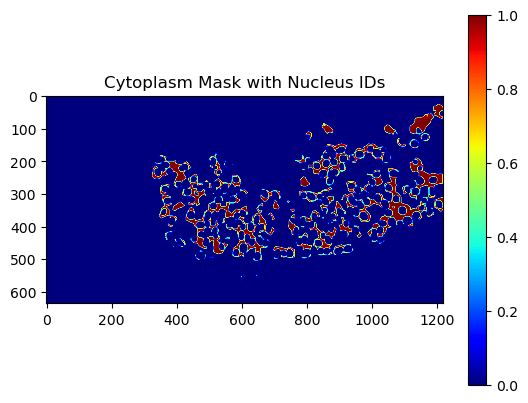

nucleus_id: 455
nucleus_pixels: [[188 384]
 [188 385]
 [188 386]
 [189 382]
 [189 383]
 [189 384]
 [189 385]
 [189 386]
 [189 387]
 [190 376]
 [190 377]
 [190 378]
 [190 379]
 [190 380]
 [190 381]
 [190 382]
 [190 383]
 [190 384]
 [190 385]
 [190 386]
 [190 387]
 [190 388]
 [191 374]
 [191 375]
 [191 376]
 [191 377]
 [191 378]
 [191 379]
 [191 380]
 [191 381]
 [191 382]
 [191 383]
 [191 384]
 [191 385]
 [191 386]
 [191 387]
 [191 388]
 [191 389]
 [191 390]
 [191 391]
 [192 372]
 [192 373]
 [192 374]
 [192 375]
 [192 376]
 [192 377]
 [192 378]
 [192 379]
 [192 380]
 [192 381]
 [192 382]
 [192 383]
 [192 384]
 [192 385]
 [192 386]
 [192 387]
 [192 388]
 [192 389]
 [192 390]
 [192 391]
 [192 392]
 [193 370]
 [193 371]
 [193 372]
 [193 373]
 [193 374]
 [193 375]
 [193 376]
 [193 377]
 [193 378]
 [193 379]
 [193 380]
 [193 381]
 [193 382]
 [193 383]
 [193 384]
 [193 385]
 [193 386]
 [193 387]
 [193 388]
 [193 389]
 [193 390]
 [193 391]
 [193 392]
 [193 393]
 [194 370]
 [194 371]
 [194 372]


ValueError: min() arg is an empty sequence

In [91]:
mod_erk_dir = 'H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/erk_cut/'
masks_dir = 'H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/nuc_mask/'
tissue_mask_dir = 'H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/tissue/'
membrane_dir = 'H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/mem_mask/'
loi_dir = 'H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/loi/'

plots_bin_smoothed, plots_smoothed= complete_function(mod_erk_dir, masks_dir, tissue_mask_dir, membrane_dir, loi_dir)